In [34]:
!pip install wandb

In [92]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import RMSprop
import wandb
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

In [93]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
run = wandb.init(project="7_7_face")

In [67]:
config = wandb.config

In [68]:
wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models.keras"),
]

In [ ]:
dataset_path = "/content/drive/MyDrive/dataset/Akhund-and-Human"

image_data_generator = ImageDataGenerator(
    rescale=1./255.0,
    validation_split=0.1,
    horizontal_flip=True,
    brightness_range=(0.9,1.1)
  )

dataset_train = image_data_generator.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    shuffle=True,
    subset="training",
    class_mode="categorical",
    batch_size=32
)

dataset_validation = image_data_generator.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    subset="validation",
    class_mode="categorical",
    shuffle=False,
    batch_size=32
)



print(dataset_train.class_indices)

In [102]:
my_model = MobileNetV2(input_shape=(224,224,3),
    weights='imagenet',
    include_top=False,
    pooling="avg",
    classes=2
)

In [103]:
my_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_23[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [104]:
for layer in my_model.layers[:-4]:
    layer.trainable = False

In [105]:
model = models.Sequential([

    my_model,
    layers.Dropout(0.4),
    layers.Dense(2, activation='softmax')
])


model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [106]:
history = model.fit(dataset_train, batch_size=32, epochs=5, validation_data=dataset_validation, callbacks=wandb_callbacks)

Epoch 1/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.7784 - loss: 0.4990 - val_accuracy: 0.8444 - val_loss: 0.6576
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9726 - loss: 0.0757 - val_accuracy: 0.8222 - val_loss: 0.9922
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9930 - loss: 0.0223 - val_accuracy: 0.8000 - val_loss: 1.1033
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.8667 - val_loss: 0.7792
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.8667 - val_loss: 0.8764


In [107]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,675,270 (10.21 MB)

 Trainable params: 414,722 (1.58 MB)

 Non-trainable params: 1,845,824 (7.04 MB)

 Optimizer params: 414,724 (1.58 MB)

In [108]:
model.save("model.h5")

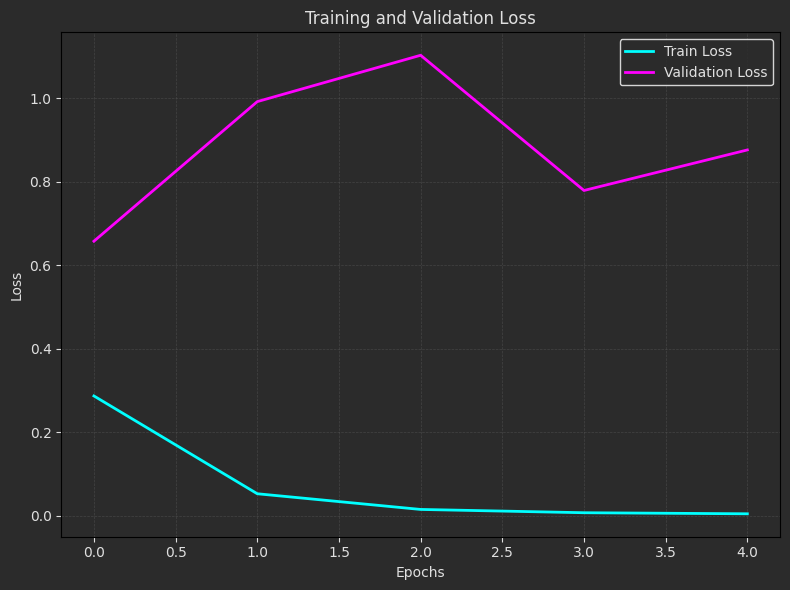

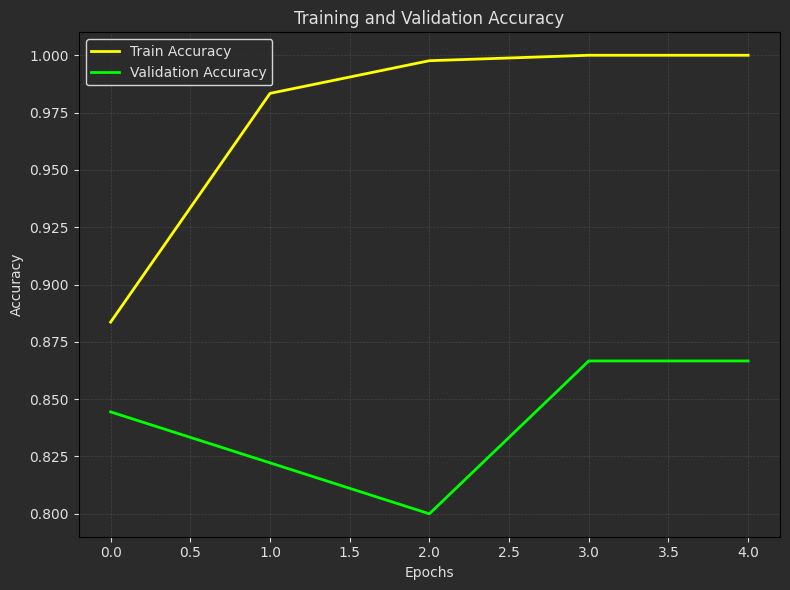

In [109]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#2b2b2b')

ax.plot(history.history['loss'], label='Train Loss', color='cyan', linewidth=2)
ax.plot(history.history['val_loss'], label='Validation Loss', color='magenta', linewidth=2)

ax.set_title('Training and Validation Loss', color='#e0e0e0')
ax.set_xlabel('Epochs', color='#e0e0e0')
ax.set_ylabel('Loss', color='#e0e0e0')
ax.tick_params(colors='#e0e0e0')
ax.grid(color='#555555', linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_facecolor('#2b2b2b')
ax.legend(facecolor='#2b2b2b', edgecolor='white', labelcolor='#e0e0e0')

plt.tight_layout()



fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#2b2b2b')

ax.plot(history.history['accuracy'], label='Train Accuracy', color='yellow', linewidth=2)
ax.plot(history.history['val_accuracy'], label='Validation Accuracy', color='lime', linewidth=2)

ax.set_title('Training and Validation Accuracy', color='#e0e0e0')
ax.set_xlabel('Epochs', color='#e0e0e0')
ax.set_ylabel('Accuracy', color='#e0e0e0')
ax.tick_params(colors='#e0e0e0')
ax.grid(color='#555555', linestyle='--', linewidth=0.5, alpha=0.6)
ax.set_facecolor('#2b2b2b')
ax.legend(facecolor='#2b2b2b', edgecolor='white', labelcolor='#e0e0e0')

plt.tight_layout()

In [111]:
y_gt = dataset_validation.classes
y_pred = model.predict(dataset_validation)
y_pred = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_gt, y_pred)
conf_matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 919ms/step


array([[24,  0],
       [ 6, 15]])

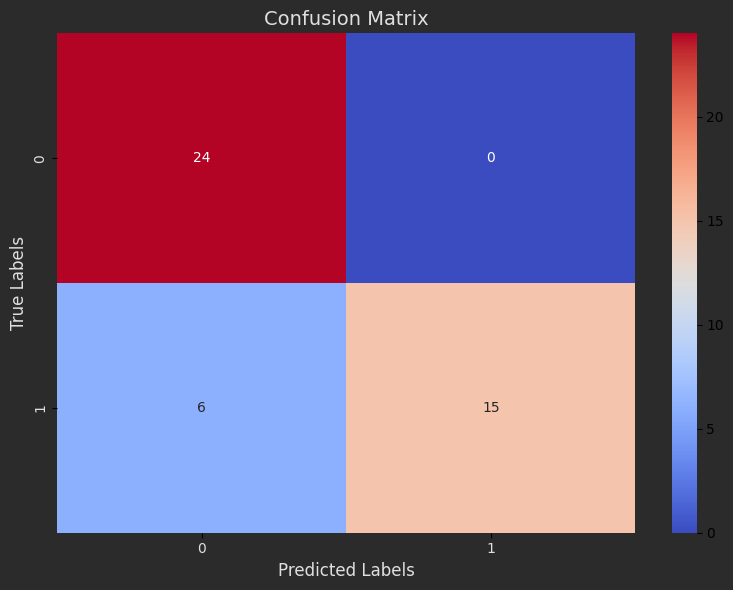

In [112]:
import seaborn as sns

plt.figure(figsize=(8, 6))
fig = plt.gcf()
fig.patch.set_facecolor('#2b2b2b')

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix", fontsize=14, color='#e0e0e0')
plt.xlabel("Predicted Labels", fontsize=12, color='#e0e0e0')
plt.ylabel("True Labels", fontsize=12, color='#e0e0e0')
plt.xticks(color='#e0e0e0')
plt.yticks(color='#e0e0e0')

plt.tight_layout()
plt.show()


In [114]:
image_test_1 = cv2.imread("/content/02.jpg",1)
image_test_1 = cv2.resize(image_test_1,(224,224))
image_test_1 = image_test_1 / 255.0

test_1 = model.predict(np.array([image_test_1]))
predicted_class = np.argmax(test_1)


if predicted_class == 0:
    print("از ما نیست!")
elif predicted_class == 1:
    print("از ماست!")



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
از ماست!


In [115]:
!pip install python-telegram-bot --upgrade
!pip install asyncio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 673.5/673.5 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 9.2 MB/s eta 0:00:00


In [ ]:
import nest_asyncio
import asyncio
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, filters
import tensorflow as tf
import cv2
import numpy as np


nest_asyncio.apply()


model = tf.keras.models.load_model("/content/model.h5")


class_mapping = {
    0: "از ما نیست",
    1: "از ماست",
}


TOKEN = ""


async def start(update, context):
    await update.message.reply_text("Welcome! Send me an image.")


async def handle_image(update, context):

    photo = await update.message.photo[-1].get_file()
    photo_path = "received_image.jpg"
    await photo.download_to_drive(photo_path)


    image = cv2.imread(photo_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)


    predictions = model.predict(image)
    predicted_class = np.argmax(predictions)
    flower_name = class_mapping[predicted_class]


    await update.message.reply_text(f"This Person : {flower_name}")


async def main():

    application = ApplicationBuilder().token(TOKEN).build()


    application.add_handler(CommandHandler("start", start))
    application.add_handler(MessageHandler(filters.PHOTO, handle_image))


    await application.run_polling()

if __name__ == "__main__":
    asyncio.run(main())


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


RuntimeError: Cannot close a running event loop